# LSTM Autoencoder para Detección de Fraude Crediticio



In [1]:
# ========================================
# LSTM MEJORADO PARA DETECCIÓN DE FRAUDE
# Detecta inconsistencias y patrones sospechosos
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

print("=" * 60)
print("CARGANDO Y PREPARANDO DATOS PARA DETECCIÓN DE FRAUDE")
print("=" * 60)

# Cargar dataset principal
df = pd.read_csv("../../data/data/application_train.csv")
print(f"\n✅ Dataset cargado: {df.shape}")
print(f"✅ Casos de fraude (TARGET=1): {df['TARGET'].sum()} ({df['TARGET'].mean()*100:.2f}%)")

# ========================================
# CREAR VARIABLES DE INCONSISTENCIA
# ========================================

print("\n" + "=" * 60)
print("CREANDO INDICADORES DE INCONSISTENCIAS SOSPECHOSAS")
print("=" * 60)

# 1. Ratio ingresos vs crédito (sobreendeudamiento)
df['RATIO_CREDITO_INGRESO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)

# 2. Ratio crédito vs precio del bien (pide más de lo necesario)
df['RATIO_CREDITO_PRECIO'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'] + 1)

# 3. Zona cara vs ingresos bajos (SOSPECHOSO)
df['ZONA_CARA'] = (
    (df['APARTMENTS_AVG'].fillna(0) > df['APARTMENTS_AVG'].median()) |
    (df['LIVINGAREA_AVG'].fillna(0) > df['LIVINGAREA_AVG'].median()) |
    (df['ELEVATORS_AVG'].fillna(0) > 0.5)
).astype(int)

df['INGRESOS_BAJOS'] = (df['AMT_INCOME_TOTAL'] < df['AMT_INCOME_TOTAL'].quantile(0.25)).astype(int)
df['INCONSISTENCIA_ZONA_INGRESO'] = (df['ZONA_CARA'] == 1) & (df['INGRESOS_BAJOS'] == 1)

# 4. Sin empleo pero tiene activos (SOSPECHOSO)
df['DIAS_EMPLEADO_POSITIVO'] = (df['DAYS_EMPLOYED'] > 0).astype(int)  # Valor positivo = sin empleo
df['TIENE_AUTO'] = (df['FLAG_OWN_CAR'] == 'Y').astype(int)
df['TIENE_CASA'] = (df['FLAG_OWN_REALTY'] == 'Y').astype(int)
df['INCONSISTENCIA_EMPLEO_ACTIVOS'] = (
    (df['DIAS_EMPLEADO_POSITIVO'] == 1) & 
    ((df['TIENE_AUTO'] == 1) | (df['TIENE_CASA'] == 1))
).astype(int)

# 5. Educación baja pero ingresos muy altos (SOSPECHOSO)
educacion_baja = df['NAME_EDUCATION_TYPE'].isin(['Lower secondary', 'Incomplete higher'])
ingresos_altos = df['AMT_INCOME_TOTAL'] > df['AMT_INCOME_TOTAL'].quantile(0.75)
df['INCONSISTENCIA_EDUCACION_INGRESO'] = (educacion_baja & ingresos_altos).astype(int)

# 6. Múltiples consultas de crédito recientes (comportamiento sospechoso)
df['CONSULTAS_CREDITO_RECIENTES'] = (
    df['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(0) +
    df['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(0) +
    df['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(0)
)
df['MUCHAS_CONSULTAS'] = (df['CONSULTAS_CREDITO_RECIENTES'] > 2).astype(int)

# 7. Dirección registrada != dirección de trabajo (puede ser fraudulento)
df['DIRECCIONES_NO_COINCIDEN'] = (
    (df['REG_REGION_NOT_WORK_REGION'] == 1) |
    (df['REG_CITY_NOT_WORK_CITY'] == 1) |
    (df['LIVE_REGION_NOT_WORK_REGION'] == 1)
).astype(int)

# 8. Círculo social con defaults
df['CIRCULO_RIESGOSO'] = (
    (df['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0) > 0) |
    (df['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0) > 0)
).astype(int)

# 9. Edad del auto vs ingreso (auto muy nuevo con ingresos bajos)
df['AUTO_NUEVO_INGRESO_BAJO'] = (
    (df['OWN_CAR_AGE'].fillna(999) < 3) & 
    (df['INGRESOS_BAJOS'] == 1)
).astype(int)

# 10. Score de inconsistencia total
df['TOTAL_INCONSISTENCIAS'] = (
    df['INCONSISTENCIA_ZONA_INGRESO'].astype(int) +
    df['INCONSISTENCIA_EMPLEO_ACTIVOS'].astype(int) +
    df['INCONSISTENCIA_EDUCACION_INGRESO'].astype(int) +
    df['MUCHAS_CONSULTAS'].astype(int) +
    df['DIRECCIONES_NO_COINCIDEN'].astype(int) +
    df['CIRCULO_RIESGOSO'].astype(int) +
    df['AUTO_NUEVO_INGRESO_BAJO'].astype(int)
)

print(f"\n✅ Casos con zona cara + ingresos bajos: {df['INCONSISTENCIA_ZONA_INGRESO'].sum()}")
print(f"✅ Casos sin empleo pero con activos: {df['INCONSISTENCIA_EMPLEO_ACTIVOS'].sum()}")
print(f"✅ Casos con educación baja + ingresos altos: {df['INCONSISTENCIA_EDUCACION_INGRESO'].sum()}")
print(f"✅ Casos con 3+ inconsistencias: {(df['TOTAL_INCONSISTENCIAS'] >= 3).sum()}")

# Seleccionar variables clave para el LSTM
variables_seleccionadas = [
    # Información financiera
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'RATIO_CREDITO_INGRESO', 'RATIO_CREDITO_PRECIO',
    
    # Información demográfica
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    
    # Vivienda y zona
    'APARTMENTS_AVG', 'LIVINGAREA_AVG', 'ELEVATORS_AVG', 
    'COMMONAREA_AVG', 'FLOORSMAX_AVG', 'REGION_POPULATION_RELATIVE',
    
    # Fuentes externas (credit scores)
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    
    # Indicadores de inconsistencia
    'INCONSISTENCIA_ZONA_INGRESO', 'INCONSISTENCIA_EMPLEO_ACTIVOS',
    'INCONSISTENCIA_EDUCACION_INGRESO', 'MUCHAS_CONSULTAS',
    'DIRECCIONES_NO_COINCIDEN', 'CIRCULO_RIESGOSO', 
    'AUTO_NUEVO_INGRESO_BAJO', 'TOTAL_INCONSISTENCIAS',
    
    # Círculo social
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    
    # Activos
    'TIENE_AUTO', 'TIENE_CASA', 'OWN_CAR_AGE',
    
    # Consultas de crédito
    'CONSULTAS_CREDITO_RECIENTES',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT'
]

# Preparar datos
X = df[variables_seleccionadas].copy()
y = df['TARGET'].copy()
ids = df['SK_ID_CURR'].copy()

# Tratar valores nulos
X = X.fillna(X.median())

# Escalar con RobustScaler (mejor para outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Variables seleccionadas: {len(variables_seleccionadas)}")
print(f"✅ Datos escalados: {X_scaled.shape}")

CARGANDO Y PREPARANDO DATOS PARA DETECCIÓN DE FRAUDE

✅ Dataset cargado: (307511, 122)
✅ Casos de fraude (TARGET=1): 24825 (8.07%)

CREANDO INDICADORES DE INCONSISTENCIAS SOSPECHOSAS

✅ Casos con zona cara + ingresos bajos: 14048
✅ Casos sin empleo pero con activos: 44671
✅ Casos con educación baja + ingresos altos: 3256
✅ Casos con 3+ inconsistencias: 821

✅ Dataset cargado: (307511, 122)
✅ Casos de fraude (TARGET=1): 24825 (8.07%)

CREANDO INDICADORES DE INCONSISTENCIAS SOSPECHOSAS

✅ Casos con zona cara + ingresos bajos: 14048
✅ Casos sin empleo pero con activos: 44671
✅ Casos con educación baja + ingresos altos: 3256
✅ Casos con 3+ inconsistencias: 821

✅ Variables seleccionadas: 37
✅ Datos escalados: (307511, 37)

✅ Variables seleccionadas: 37
✅ Datos escalados: (307511, 37)


In [2]:
# ========================================
# PREPARAR SECUENCIAS TEMPORALES PARA LSTM
# ========================================

print("\n" + "=" * 60)
print("CREANDO SECUENCIAS TEMPORALES")
print("=" * 60)

# Para LSTM necesitamos formato 3D: (muestras, pasos_temporales, features)
# Como no tenemos series temporales reales, crearemos ventanas deslizantes
# basadas en el orden natural de los datos

n_steps = 10  # Ventana de 10 registros
n_features = X_scaled.shape[1]

# Crear secuencias con ventana deslizante
def crear_secuencias(datos, n_steps):
    X_seq = []
    indices = []
    
    for i in range(len(datos) - n_steps + 1):
        X_seq.append(datos[i:i + n_steps])
        indices.append(i + n_steps - 1)  # Índice del último elemento
    
    return np.array(X_seq), np.array(indices)

X_seq, indices_seq = crear_secuencias(X_scaled, n_steps)
y_seq = y.iloc[indices_seq].values
ids_seq = ids.iloc[indices_seq].values

print(f"\n✅ Secuencias creadas: {X_seq.shape}")
print(f"   - Muestras: {X_seq.shape[0]}")
print(f"   - Pasos temporales: {X_seq.shape[1]}")
print(f"   - Features: {X_seq.shape[2]}")
print(f"\n✅ Casos de fraude en secuencias: {y_seq.sum()} ({y_seq.mean()*100:.2f}%)")


CREANDO SECUENCIAS TEMPORALES

✅ Secuencias creadas: (307502, 10, 37)
   - Muestras: 307502
   - Pasos temporales: 10
   - Features: 37

✅ Casos de fraude en secuencias: 24824 (8.07%)

✅ Secuencias creadas: (307502, 10, 37)
   - Muestras: 307502
   - Pasos temporales: 10
   - Features: 37

✅ Casos de fraude en secuencias: 24824 (8.07%)


In [3]:
# ========================================
# CONSTRUIR Y ENTRENAR LSTM AUTOENCODER
# ========================================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print("\n" + "=" * 60)
print("ENTRENANDO LSTM AUTOENCODER MEJORADO")
print("=" * 60)

timesteps = X_seq.shape[1]
features = X_seq.shape[2]

# Arquitectura mejorada del Autoencoder
input_layer = Input(shape=(timesteps, features))

# ENCODER (más profundo y con dropout)
encoded = LSTM(128, activation='tanh', return_sequences=True)(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = LSTM(64, activation='tanh', return_sequences=True)(encoded)
encoded = Dropout(0.2)(encoded)
encoded = LSTM(32, activation='tanh')(encoded)

# BOTTLENECK (representación comprimida)
bottleneck = RepeatVector(timesteps)(encoded)

# DECODER (reconstrucción)
decoded = LSTM(32, activation='tanh', return_sequences=True)(bottleneck)
decoded = Dropout(0.2)(decoded)
decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)
decoded = Dropout(0.2)(decoded)
decoded = LSTM(128, activation='tanh', return_sequences=True)(decoded)

# Capa de salida
output = Dense(features, activation='linear')(decoded)

# Compilar modelo
autoencoder = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print("\n📊 Arquitectura del modelo:")
autoencoder.summary()

# Callbacks para mejor entrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Entrenar el modelo
print("\n🚀 Iniciando entrenamiento...")
history = autoencoder.fit(
    X_seq, X_seq,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predecir y calcular errores
print("\n🔍 Calculando errores de reconstrucción...")
X_reconstructed = autoencoder.predict(X_seq, verbose=0)

# Error de reconstrucción por muestra
mse = np.mean(np.square(X_seq - X_reconstructed), axis=(1, 2))
mae = np.mean(np.abs(X_seq - X_reconstructed), axis=(1, 2))

# Crear DataFrame con resultados
resultados = pd.DataFrame({
    'SK_ID_CURR': ids_seq,
    'TARGET': y_seq,
    'ERROR_MSE': mse,
    'ERROR_MAE': mae
})

# Agregar información de inconsistencias
inconsistencias_seq = df.loc[indices_seq, [
    'TOTAL_INCONSISTENCIAS',
    'INCONSISTENCIA_ZONA_INGRESO',
    'INCONSISTENCIA_EMPLEO_ACTIVOS',
    'INCONSISTENCIA_EDUCACION_INGRESO',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'RATIO_CREDITO_INGRESO'
]].reset_index(drop=True)

resultados = pd.concat([resultados, inconsistencias_seq], axis=1)

# Definir umbral dinámico (percentil 95 y 99)
umbral_95 = np.percentile(mse, 95)
umbral_99 = np.percentile(mse, 99)

resultados['ANOMALO_P95'] = (mse > umbral_95).astype(int)
resultados['ANOMALO_P99'] = (mse > umbral_99).astype(int)

print(f"\n✅ Entrenamiento completado")
print(f"✅ Umbral P95: {umbral_95:.4f}")
print(f"✅ Umbral P99: {umbral_99:.4f}")
print(f"✅ Anomalías detectadas (P95): {resultados['ANOMALO_P95'].sum()} ({resultados['ANOMALO_P95'].mean()*100:.2f}%)")
print(f"✅ Anomalías detectadas (P99): {resultados['ANOMALO_P99'].sum()} ({resultados['ANOMALO_P99'].mean()*100:.2f}%)")

# Estadísticas por grupo
print("\n" + "=" * 60)
print("ESTADÍSTICAS DE DETECCIÓN")
print("=" * 60)

print("\nCasos NORMALES (TARGET=0):")
print(f"  - Error promedio: {resultados[resultados['TARGET']==0]['ERROR_MSE'].mean():.4f}")
print(f"  - Detectados como anomalía (P95): {resultados[(resultados['TARGET']==0) & (resultados['ANOMALO_P95']==1)].shape[0]}")

print("\nCasos FRAUDE (TARGET=1):")
print(f"  - Error promedio: {resultados[resultados['TARGET']==1]['ERROR_MSE'].mean():.4f}")
print(f"  - Detectados como anomalía (P95): {resultados[(resultados['TARGET']==1) & (resultados['ANOMALO_P95']==1)].shape[0]}")

# Tasa de detección
tasa_deteccion = resultados[(resultados['TARGET']==1) & (resultados['ANOMALO_P95']==1)].shape[0] / resultados[resultados['TARGET']==1].shape[0]
print(f"\n🎯 Tasa de detección de fraude (P95): {tasa_deteccion*100:.2f}%")


ENTRENANDO LSTM AUTOENCODER MEJORADO

📊 Arquitectura del modelo:

📊 Arquitectura del modelo:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 37)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10, 37)         │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,557 (1.08 MB)

 Trainable params: 283,557 (1.08 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Iniciando entrenamiento...
Epoch 1/100
Epoch 1/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 95s 92ms/step - loss: 89.1340 - mae: 1.4823 - val_loss: 78.1852 - val_mae: 1.4577 - learning_rate: 0.0010
Epoch 2/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 95s 92ms/step - loss: 89.1340 - mae: 1.4823 - val_loss: 78.1852 - val_mae: 1.4577 - learning_rate: 0.0010
Epoch 2/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 92s 96ms/step - loss: 78.3858 - mae: 1.4582 - val_loss: 77.6445 - val_mae: 1.4519 - learning_rate: 0.0010
Epoch 3/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 92s 96ms/step - loss: 78.3858 - mae: 1.4582 - val_loss: 77.6445 - val_mae: 1.4519 - learning_rate: 0.0010
Epoch 3/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 87s 91ms/step - loss: 77.5973 - mae: 1.4564 - val_loss: 74.1704 - val_mae: 1.4340 - learning_rate: 0.0010
Epoch 4/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 87s 91ms/step - loss: 77.5973 - mae: 1.4564 - val_loss: 74.1704 - val_mae: 1.4340 - learning_rate: 0.0010
Epoch 4/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 91s 95ms/step - loss: 73.9283 - mae

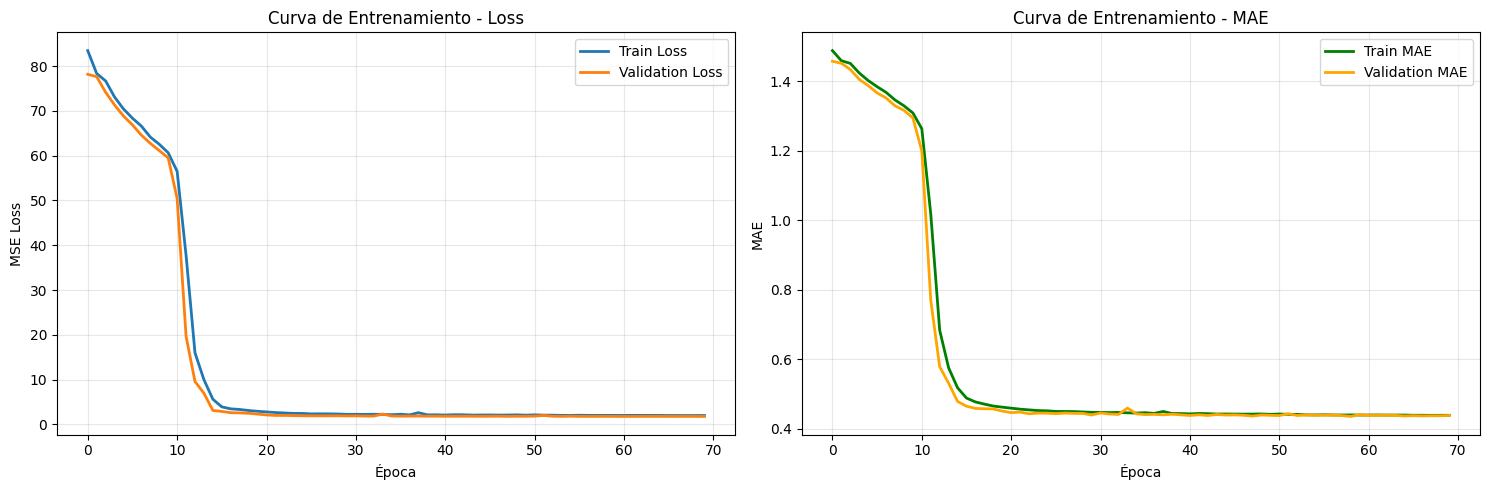

In [4]:
# ========================================
# VISUALIZACIÓN 1: CURVAS DE ENTRENAMIENTO
# ========================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Época')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Curva de Entrenamiento - Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# MAE
ax2.plot(history.history['mae'], label='Train MAE', linewidth=2, color='green')
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='orange')
ax2.set_xlabel('Época')
ax2.set_ylabel('MAE')
ax2.set_title('Curva de Entrenamiento - MAE')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\EQUIPO\AppData\Local\Temp\ipykernel_16700\920691215.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(


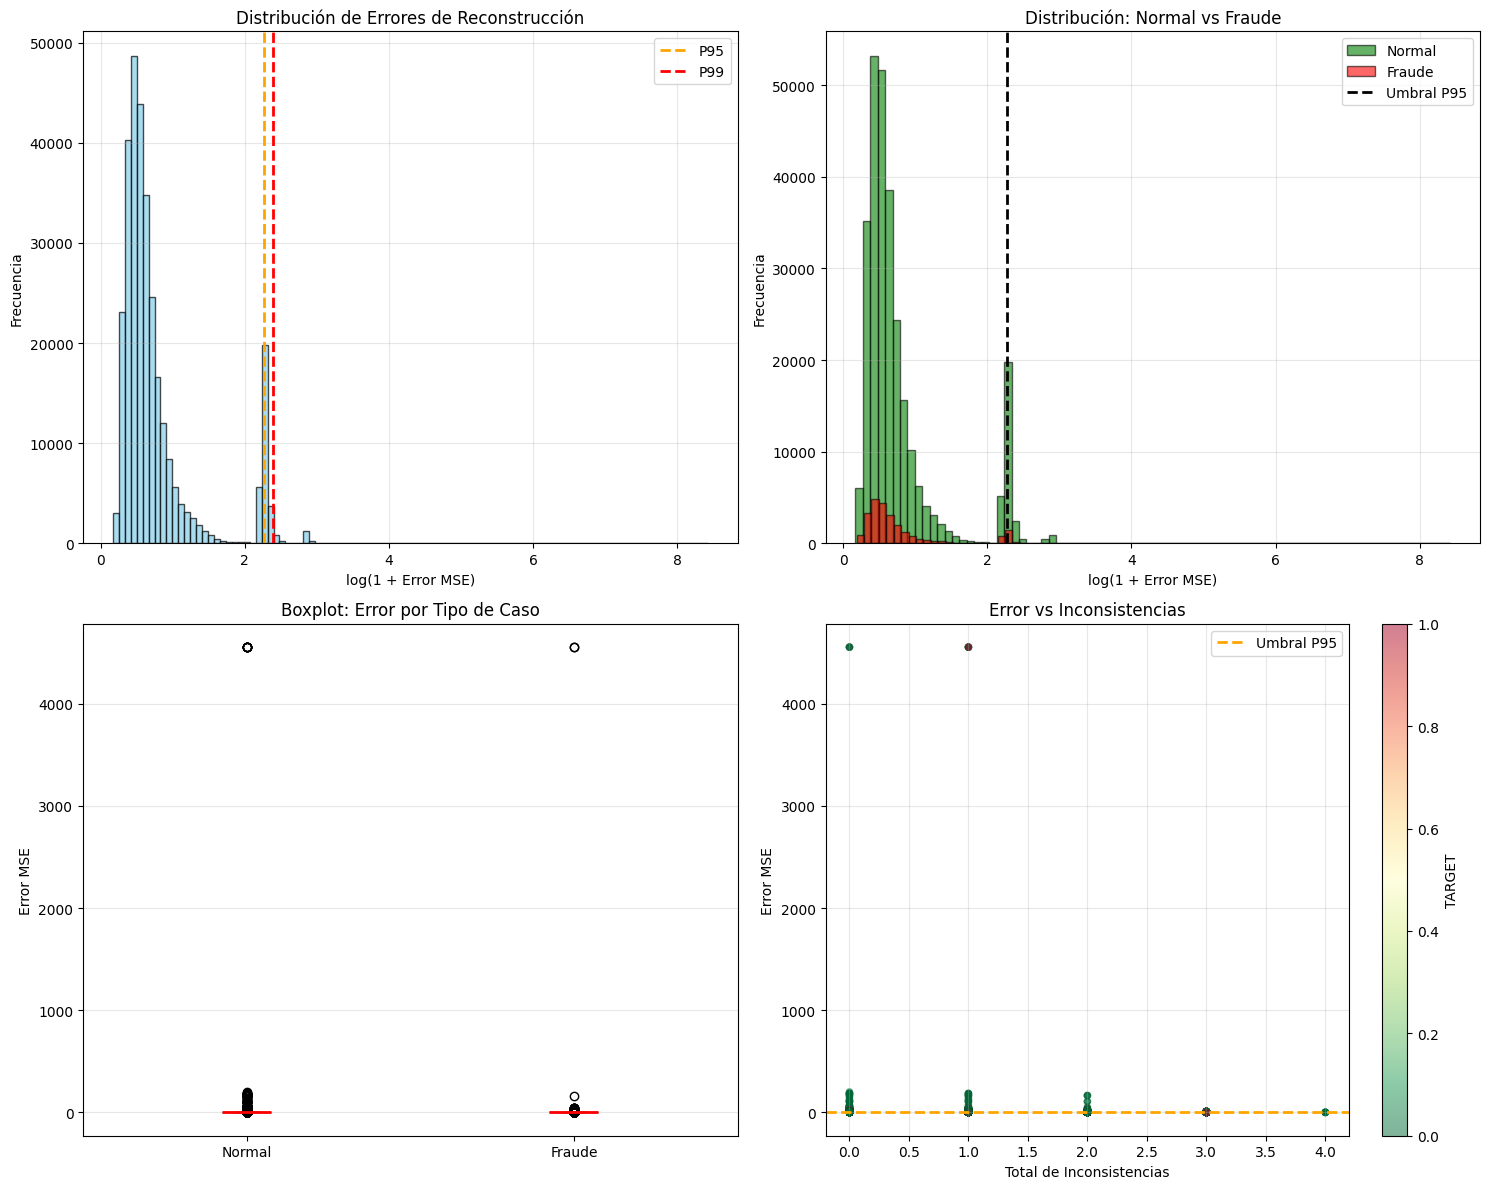

In [5]:
# ========================================
# VISUALIZACIÓN 2: DISTRIBUCIÓN DE ERRORES
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución general de errores (log scale)
axes[0, 0].hist(np.log1p(mse), bins=100, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.log1p(umbral_95), color='orange', linestyle='--', linewidth=2, label='P95')
axes[0, 0].axvline(np.log1p(umbral_99), color='red', linestyle='--', linewidth=2, label='P99')
axes[0, 0].set_xlabel('log(1 + Error MSE)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Errores de Reconstrucción')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Comparación Normal vs Fraude
normales = resultados[resultados['TARGET'] == 0]['ERROR_MSE']
fraudulentos = resultados[resultados['TARGET'] == 1]['ERROR_MSE']

axes[0, 1].hist(np.log1p(normales), bins=80, alpha=0.6, color='green', label='Normal', edgecolor='black')
axes[0, 1].hist(np.log1p(fraudulentos), bins=80, alpha=0.6, color='red', label='Fraude', edgecolor='black')
axes[0, 1].axvline(np.log1p(umbral_95), color='black', linestyle='--', linewidth=2, label='Umbral P95')
axes[0, 1].set_xlabel('log(1 + Error MSE)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución: Normal vs Fraude')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Boxplot comparativo
axes[1, 0].boxplot(
    [normales, fraudulentos],
    labels=['Normal', 'Fraude'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', alpha=0.7),
    medianprops=dict(color='red', linewidth=2)
)
axes[1, 0].set_ylabel('Error MSE')
axes[1, 0].set_title('Boxplot: Error por Tipo de Caso')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Error vs Total de Inconsistencias
scatter = axes[1, 1].scatter(
    resultados['TOTAL_INCONSISTENCIAS'],
    resultados['ERROR_MSE'],
    c=resultados['TARGET'],
    cmap='RdYlGn_r',
    alpha=0.5,
    s=20
)
axes[1, 1].axhline(umbral_95, color='orange', linestyle='--', linewidth=2, label='Umbral P95')
axes[1, 1].set_xlabel('Total de Inconsistencias')
axes[1, 1].set_ylabel('Error MSE')
axes[1, 1].set_title('Error vs Inconsistencias')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='TARGET')

plt.tight_layout()
plt.show()

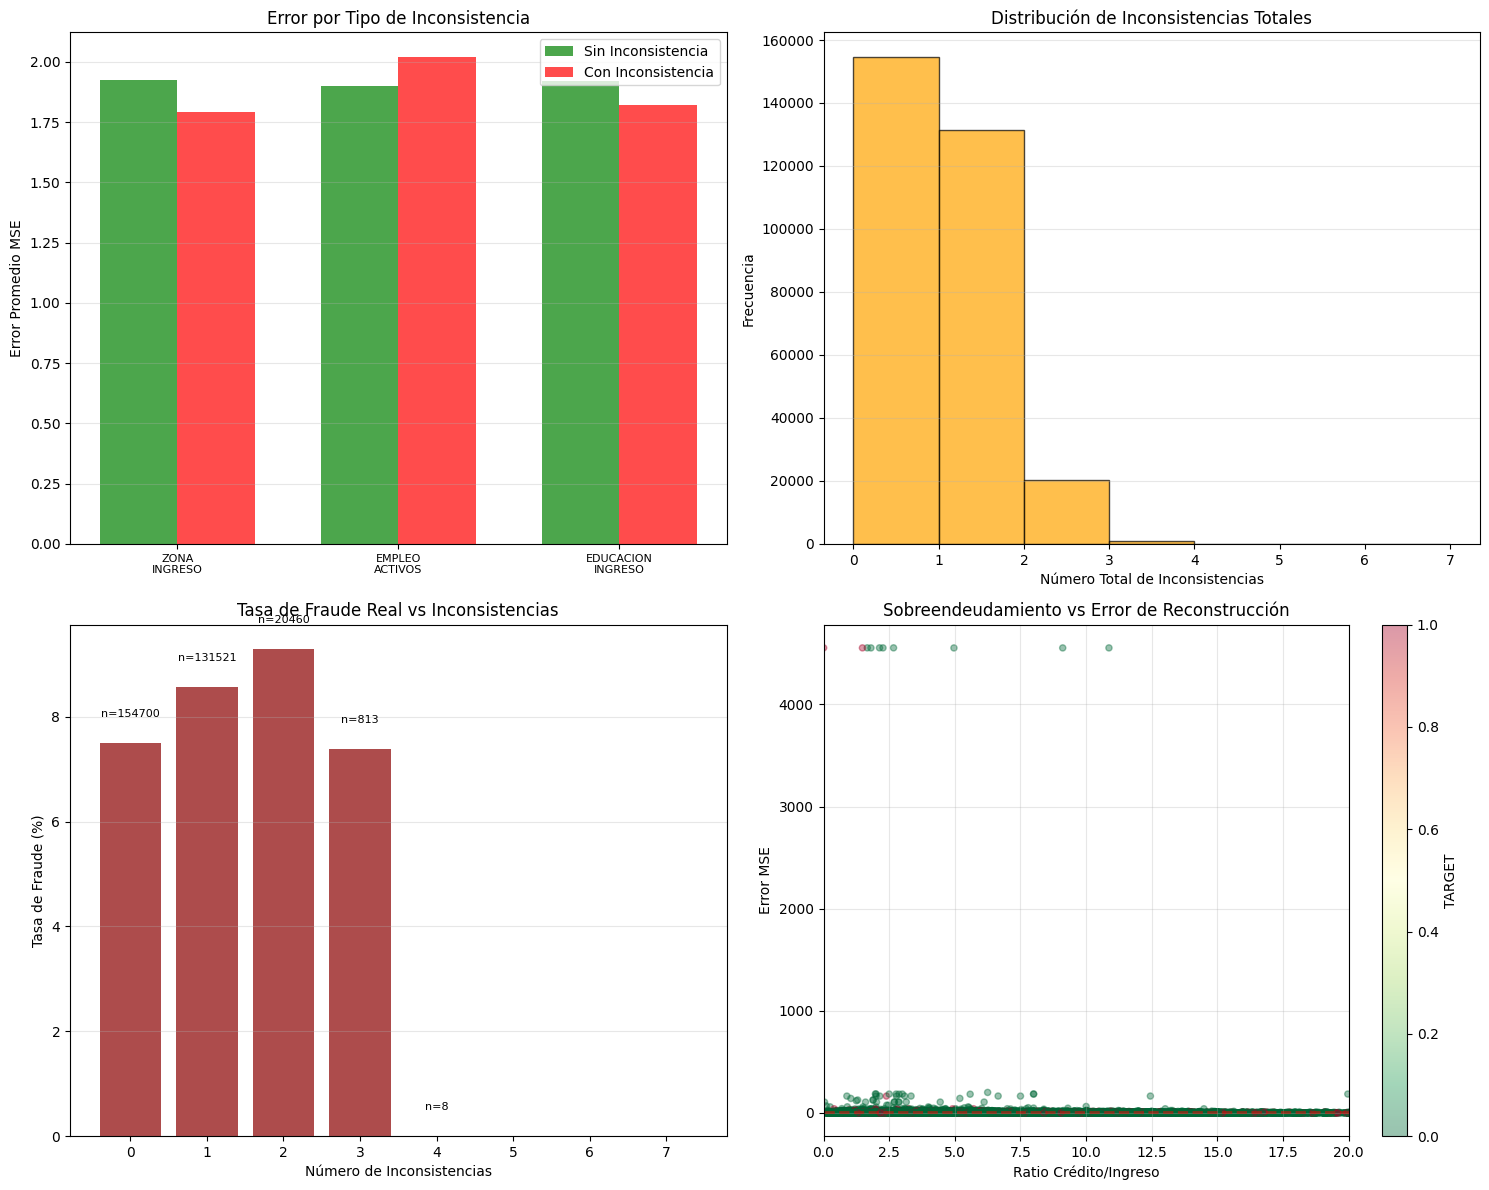

In [6]:
# ========================================
# VISUALIZACIÓN 3: ANÁLISIS DE INCONSISTENCIAS
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Error por tipo de inconsistencia
inconsistencias_cols = [
    'INCONSISTENCIA_ZONA_INGRESO',
    'INCONSISTENCIA_EMPLEO_ACTIVOS',
    'INCONSISTENCIA_EDUCACION_INGRESO',
    'MUCHAS_CONSULTAS'
]

errores_por_tipo = []
nombres_tipos = []
for col in inconsistencias_cols:
    if col in resultados.columns:
        error_con = resultados[resultados[col] == 1]['ERROR_MSE'].mean()
        error_sin = resultados[resultados[col] == 0]['ERROR_MSE'].mean()
        errores_por_tipo.append([error_sin, error_con])
        nombres_tipos.append(col.replace('INCONSISTENCIA_', '').replace('_', '\n'))

x_pos = np.arange(len(nombres_tipos))
width = 0.35

axes[0, 0].bar(x_pos - width/2, [e[0] for e in errores_por_tipo], width, 
               label='Sin Inconsistencia', color='green', alpha=0.7)
axes[0, 0].bar(x_pos + width/2, [e[1] for e in errores_por_tipo], width,
               label='Con Inconsistencia', color='red', alpha=0.7)
axes[0, 0].set_ylabel('Error Promedio MSE')
axes[0, 0].set_title('Error por Tipo de Inconsistencia')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(nombres_tipos, fontsize=8)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Distribución de inconsistencias totales
axes[0, 1].hist(resultados['TOTAL_INCONSISTENCIAS'], bins=range(0, 8), 
                color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Número Total de Inconsistencias')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Inconsistencias Totales')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Tasa de fraude por nivel de inconsistencias
tasas_fraude = []
conteos = []
for i in range(8):
    grupo = resultados[resultados['TOTAL_INCONSISTENCIAS'] == i]
    if len(grupo) > 0:
        tasa = grupo['TARGET'].mean() * 100
        tasas_fraude.append(tasa)
        conteos.append(len(grupo))
    else:
        tasas_fraude.append(0)
        conteos.append(0)

axes[1, 0].bar(range(8), tasas_fraude, color='darkred', alpha=0.7)
axes[1, 0].set_xlabel('Número de Inconsistencias')
axes[1, 0].set_ylabel('Tasa de Fraude (%)')
axes[1, 0].set_title('Tasa de Fraude Real vs Inconsistencias')
axes[1, 0].grid(axis='y', alpha=0.3)

# Añadir conteos encima de las barras
for i, (tasa, conteo) in enumerate(zip(tasas_fraude, conteos)):
    if conteo > 0:
        axes[1, 0].text(i, tasa + 0.5, f'n={conteo}', ha='center', fontsize=8)

# 4. Scatter: Ratio Crédito/Ingreso vs Error
scatter = axes[1, 1].scatter(
    resultados['RATIO_CREDITO_INGRESO'],
    resultados['ERROR_MSE'],
    c=resultados['TARGET'],
    cmap='RdYlGn_r',
    alpha=0.4,
    s=20
)
axes[1, 1].set_xlabel('Ratio Crédito/Ingreso')
axes[1, 1].set_ylabel('Error MSE')
axes[1, 1].set_title('Sobreendeudamiento vs Error de Reconstrucción')
axes[1, 1].set_xlim(0, 20)
axes[1, 1].axhline(umbral_95, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='TARGET')

plt.tight_layout()
plt.show()


TOP 20 CASOS MÁS SOSPECHOSOS DETECTADOS POR LSTM

  SK_ID_CURR  TARGET   ERROR_MSE  ANOMALO_P95  TOTAL_INCONSISTENCIAS  AMT_INCOME_TOTAL  AMT_CREDIT  RATIO_CREDITO_INGRESO  INCONSISTENCIA_ZONA_INGRESO  INCONSISTENCIA_EMPLEO_ACTIVOS  INCONSISTENCIA_EDUCACION_INGRESO
     114967       1 4554.562561            1                      0       117000000.0    562491.0               0.004808                        False                              0                                 0
     114969       0 4554.544514            1                      0          180000.0    299772.0               1.665391                        False                              0                                 0
     114968       0 4554.530210            1                      1          135000.0    360000.0               2.666647                        False                              0                                 0
     114970       0 4554.518942            1                      1          129600.0   

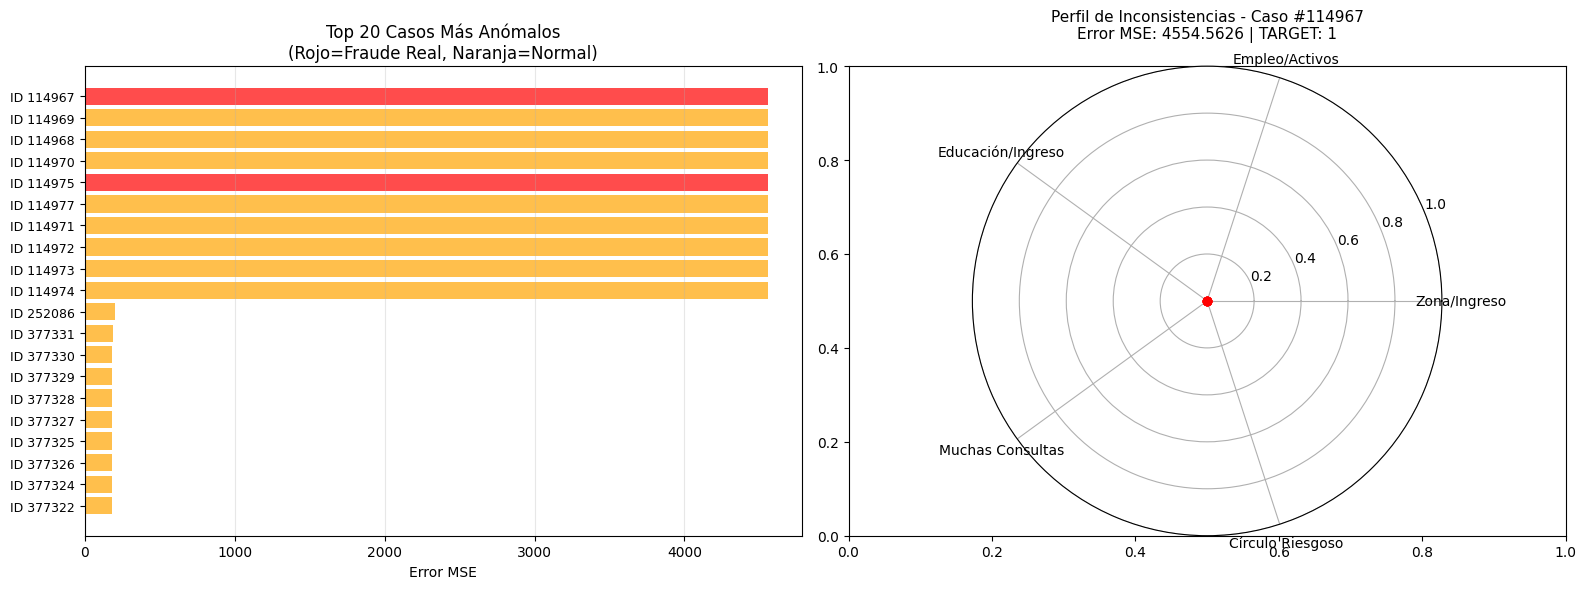


✅ De los top 20 casos anómalos, 2 son fraudes reales
✅ Precisión en top 20: 10.00%


In [7]:
# ========================================
# TOP 20 CASOS MÁS SOSPECHOSOS
# ========================================

print("\n" + "=" * 80)
print("TOP 20 CASOS MÁS SOSPECHOSOS DETECTADOS POR LSTM")
print("=" * 80)

# Ordenar por error y tomar top 20
top_sospechosos = resultados.nlargest(20, 'ERROR_MSE')

# Mostrar información detallada
display_cols = [
    'SK_ID_CURR', 'TARGET', 'ERROR_MSE', 'ANOMALO_P95',
    'TOTAL_INCONSISTENCIAS', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'RATIO_CREDITO_INGRESO', 'INCONSISTENCIA_ZONA_INGRESO',
    'INCONSISTENCIA_EMPLEO_ACTIVOS', 'INCONSISTENCIA_EDUCACION_INGRESO'
]

print("\n", top_sospechosos[display_cols].to_string(index=False))

# Visualizar top 20
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Barras de error
colores = ['red' if t == 1 else 'orange' for t in top_sospechosos['TARGET']]
ax1.barh(range(20), top_sospechosos['ERROR_MSE'].values, color=colores, alpha=0.7)
ax1.set_yticks(range(20))
ax1.set_yticklabels([f"ID {id}" for id in top_sospechosos['SK_ID_CURR'].values], fontsize=9)
ax1.set_xlabel('Error MSE')
ax1.set_title('Top 20 Casos Más Anómalos\n(Rojo=Fraude Real, Naranja=Normal)')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Gráfico 2: Radar de inconsistencias del top 1
caso_top = top_sospechosos.iloc[0]
categorias = ['Zona/Ingreso', 'Empleo/Activos', 'Educación/Ingreso', 
              'Muchas Consultas', 'Círculo Riesgoso']
valores = [
    caso_top.get('INCONSISTENCIA_ZONA_INGRESO', 0),
    caso_top.get('INCONSISTENCIA_EMPLEO_ACTIVOS', 0),
    caso_top.get('INCONSISTENCIA_EDUCACION_INGRESO', 0),
    caso_top.get('MUCHAS_CONSULTAS', 0) if 'MUCHAS_CONSULTAS' in caso_top else 0,
    1 if caso_top.get('TOTAL_INCONSISTENCIAS', 0) >= 3 else 0
]

from math import pi
N = len(categorias)
angles = [n / float(N) * 2 * pi for n in range(N)]
valores += valores[:1]
angles += angles[:1]

ax2 = plt.subplot(122, projection='polar')
ax2.plot(angles, valores, 'o-', linewidth=2, color='red')
ax2.fill(angles, valores, alpha=0.25, color='red')
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categorias, size=10)
ax2.set_ylim(0, 1)
ax2.set_title(f'Perfil de Inconsistencias - Caso #{caso_top["SK_ID_CURR"]}\n' +
              f'Error MSE: {caso_top["ERROR_MSE"]:.4f} | TARGET: {int(caso_top["TARGET"])}',
              size=11, pad=20)
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✅ De los top 20 casos anómalos, {top_sospechosos['TARGET'].sum()} son fraudes reales")
print(f"✅ Precisión en top 20: {top_sospechosos['TARGET'].mean()*100:.2f}%")


MÉTRICAS DE DESEMPEÑO DEL MODELO

📊 Matriz de Confusión:
[[268541  14137]
 [ 23585   1239]]

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       0.92      0.95      0.93    282678
      Fraude       0.08      0.05      0.06     24824

    accuracy                           0.88    307502
   macro avg       0.50      0.50      0.50    307502
weighted avg       0.85      0.88      0.86    307502

              precision    recall  f1-score   support

      Normal       0.92      0.95      0.93    282678
      Fraude       0.08      0.05      0.06     24824

    accuracy                           0.88    307502
   macro avg       0.50      0.50      0.50    307502
weighted avg       0.85      0.88      0.86    307502


🎯 ROC AUC Score: 0.5018

🎯 ROC AUC Score: 0.5018


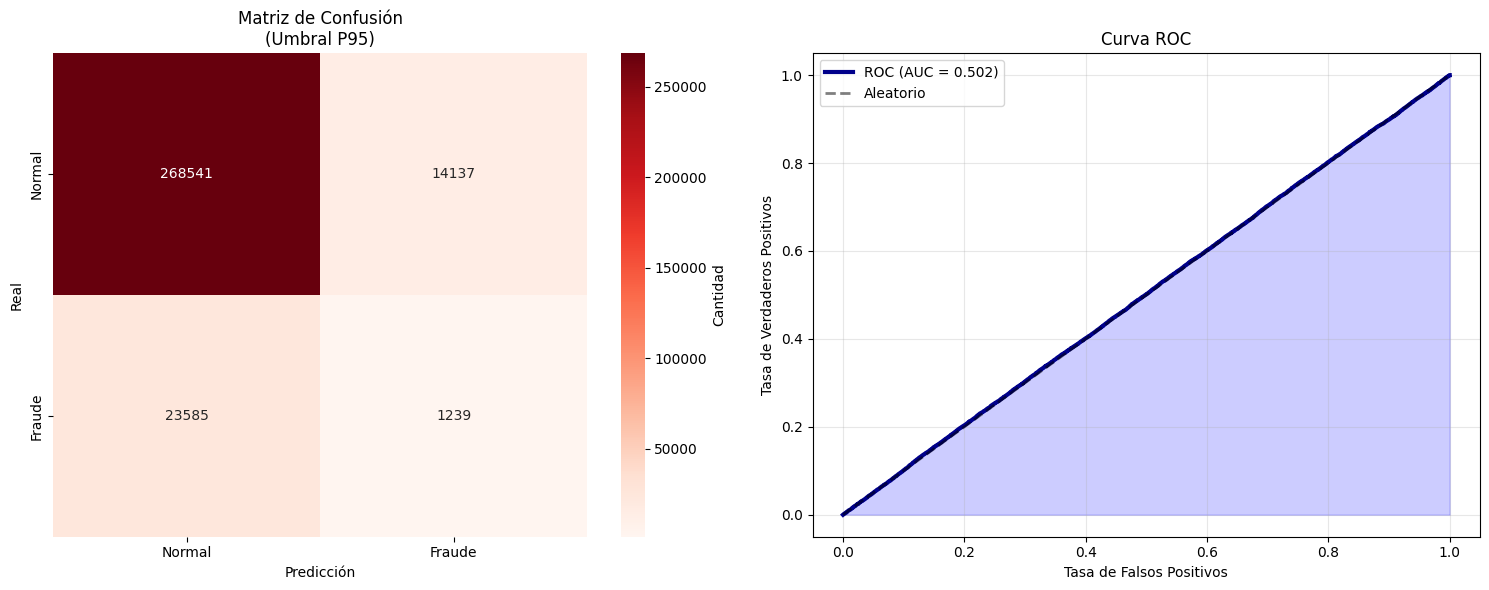


RESUMEN EJECUTIVO

✅ Total de casos analizados: 307,502
✅ Casos de fraude reales: 24,824 (8.07%)
✅ Anomalías detectadas (P95): 15,376 (5.00%)
✅ Fraudes correctamente detectados: 1,239
✅ Tasa de detección: 4.99%
✅ Falsos positivos: 14,137
✅ Casos con 3+ inconsistencias: 821


In [10]:
# ========================================
# MÉTRICAS DE DESEMPEÑO
# ========================================

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("\n" + "=" * 80)
print("MÉTRICAS DE DESEMPEÑO DEL MODELO")
print("=" * 80)

# Usar umbral P95 como clasificador
y_pred = resultados['ANOMALO_P95'].values
y_true = resultados['TARGET'].values

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n📊 Matriz de Confusión:")
print(cm)

# Classification Report
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Fraude']))

# ROC AUC
try:
    roc_auc = roc_auc_score(y_true, resultados['ERROR_MSE'].values)
    print(f"\n🎯 ROC AUC Score: {roc_auc:.4f}")
except:
    print("\n⚠️ No se pudo calcular ROC AUC")

# Visualizar Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax1,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            cbar_kws={'label': 'Cantidad'})
ax1.set_xlabel('Predicción')
ax1.set_ylabel('Real')
ax1.set_title('Matriz de Confusión\n(Umbral P95)')

# Curva ROC
try:
    fpr, tpr, thresholds = roc_curve(y_true, resultados['ERROR_MSE'].values)
    ax2.plot(fpr, tpr, linewidth=3, label=f'ROC (AUC = {roc_auc:.3f})', color='darkblue')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Aleatorio')
    ax2.fill_between(fpr, tpr, alpha=0.2, color='blue')
    ax2.set_xlabel('Tasa de Falsos Positivos')
    ax2.set_ylabel('Tasa de Verdaderos Positivos')
    ax2.set_title('Curva ROC')
    ax2.legend()
    ax2.grid(alpha=0.3)
except:
    ax2.text(0.5, 0.5, 'No disponible', ha='center', va='center')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("RESUMEN EJECUTIVO")
print("=" * 80)
print(f"\n✅ Total de casos analizados: {len(resultados):,}")
print(f"✅ Casos de fraude reales: {y_true.sum():,} ({y_true.mean()*100:.2f}%)")
print(f"✅ Anomalías detectadas (P95): {y_pred.sum():,} ({y_pred.mean()*100:.2f}%)")
print(f"✅ Fraudes correctamente detectados: {cm[1,1]:,}")
print(f"✅ Tasa de detección: {cm[1,1]/y_true.sum()*100:.2f}%")
print(f"✅ Falsos positivos: {cm[0,1]:,}")
print(f"✅ Casos con 3+ inconsistencias: {(resultados['TOTAL_INCONSISTENCIAS'] >= 3).sum():,}")


In [ ]:
# ========================================
# VISUALIZACIÓN TEMPORAL: EVOLUCIÓN DE VARIABLES
# ========================================

print("\n" + "=" * 80)
print("GRÁFICOS TEMPORALES: PATRONES NORMALES VS ANOMALÍAS")
print("=" * 80)

# Seleccionar casos ejemplo: normales vs anomalías detectadas
casos_normales = resultados[(resultados['TARGET'] == 0) & (resultados['ANOMALO_P95'] == 0)].sample(min(50, len(resultados[(resultados['TARGET'] == 0) & (resultados['ANOMALO_P95'] == 0)])))
casos_anomalos = resultados[(resultados['TARGET'] == 1) | (resultados['ANOMALO_P95'] == 1)].sample(min(50, len(resultados[(resultados['TARGET'] == 1) | (resultados['ANOMALO_P95'] == 1)])))

# Variables clave para visualizar (con nombres en español)
variables_temporal = {
    'AMT_CREDIT': 'Monto del Crédito',
    'AMT_INCOME_TOTAL': 'Ingresos Totales',
    'AMT_GOODS_PRICE': 'Precio del Bien',
    'AMT_ANNUITY': 'Anualidad',
    'DAYS_EMPLOYED': 'Días Empleado',
    'RATIO_CREDITO_INGRESO': 'Ratio Crédito/Ingreso'
}

# Crear DataFrame con las variables originales necesarias
df_viz = df[list(variables_temporal.keys())].copy()

# Obtener índices para visualización
idx_normales = casos_normales.index[:10].tolist()
idx_anomalos = casos_anomalos.index[:10].tolist()

fig, axes = plt.subplots(len(variables_temporal), 1, figsize=(18, 4*len(variables_temporal)))

for idx, (var, nombre) in enumerate(variables_temporal.items()):
    ax = axes[idx]
    
    # Preparar datos temporales - patrones normales
    for caso_idx in idx_normales:
        # Obtener la secuencia temporal para este caso desde las secuencias creadas
        if caso_idx < len(indices_seq):
            seq_idx = np.where(indices_seq == caso_idx)[0]
            if len(seq_idx) > 0:
                # Buscar el índice de la variable en variables_seleccionadas
                if var in variables_seleccionadas:
                    var_idx = variables_seleccionadas.index(var)
                    secuencia = X_seq[seq_idx[0], :, var_idx]
                    # Invertir la escala
                    secuencia_original = scaler.inverse_transform(
                        np.repeat(secuencia.reshape(-1, 1), X_scaled.shape[1], axis=1)
                    )[:, var_idx]
                    ax.plot(range(n_steps), secuencia_original, color='#2E86DE', alpha=0.3, linewidth=1)
    
    # Preparar datos temporales - anomalías
    for caso_idx in idx_anomalos:
        if caso_idx < len(indices_seq):
            seq_idx = np.where(indices_seq == caso_idx)[0]
            if len(seq_idx) > 0:
                if var in variables_seleccionadas:
                    var_idx = variables_seleccionadas.index(var)
                    secuencia = X_seq[seq_idx[0], :, var_idx]
                    # Invertir la escala
                    secuencia_original = scaler.inverse_transform(
                        np.repeat(secuencia.reshape(-1, 1), X_scaled.shape[1], axis=1)
                    )[:, var_idx]
                    ax.plot(range(n_steps), secuencia_original, color='#EE5A24', alpha=0.4, linewidth=1)
    
    ax.set_title(f'{nombre} - Evolución Temporal', fontsize=12, fontweight='bold')
    ax.set_xlabel('Paso Temporal (ventana de secuencia)', fontsize=10)
    ax.set_ylabel(nombre, fontsize=10)
    
    # Añadir leyenda personalizada
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#2E86DE', lw=2, label='Casos Normales'),
        Line2D([0], [0], color='#EE5A24', lw=2, label='Casos Anómalos')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Análisis Temporal: Comparación de Patrones Normales vs Anomalías', 
            fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

print(f"\n✅ Gráficos temporales generados para {len(variables_temporal)} variables")
print(f"✅ Muestras normales: {len(idx_normales)} | Muestras anómalas: {len(idx_anomalos)}")

In [14]:
# ========================================
# EXPORTAR RESULTADOS PARA COMPARACIÓN
# ========================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n" + "=" * 80)
print("EXPORTANDO MÉTRICAS PARA COMPARACIÓN CON OTROS MODELOS")
print("=" * 80)

# Calcular métricas con umbral P95
y_pred_p95 = resultados['ANOMALO_P95'].values
y_true = resultados['TARGET'].values

metricas = {
    'Modelo': 'LSTM Autoencoder',
    'Accuracy': accuracy_score(y_true, y_pred_p95),
    'Precision': precision_score(y_true, y_pred_p95, zero_division=0),
    'Recall': recall_score(y_true, y_pred_p95, zero_division=0),
    'F1-Score': f1_score(y_true, y_pred_p95, zero_division=0),
    'ROC-AUC': roc_auc_score(y_true, resultados['ERROR_MSE'].values)
}

# Crear DataFrame de métricas
df_metricas = pd.DataFrame([metricas])

print("\n MÉTRICAS DEL MODELO LSTM:")
print(df_metricas.to_string(index=False))

# Guardar métricas (comentado para no generar archivos externos)
# df_metricas.to_csv('../../data/metricas_lstm.csv', index=False)

# Mostrar en formato compatible con comparador_modelos.ipynb
print("\n" + "=" * 80)
print("FORMATO PARA COMPARADOR DE MODELOS")
print("=" * 80)
print(f"""
Modelo: LSTM Autoencoder
- Accuracy:  {metricas['Accuracy']:.4f}
- Precision: {metricas['Precision']:.4f}
- Recall:    {metricas['Recall']:.4f}
- F1-Score:  {metricas['F1-Score']:.4f}
- ROC-AUC:   {metricas['ROC-AUC']:.4f}

""")



EXPORTANDO MÉTRICAS PARA COMPARACIÓN CON OTROS MODELOS

 MÉTRICAS DEL MODELO LSTM:
          Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
LSTM Autoencoder  0.877328    0.08058 0.049911  0.061642 0.501756

FORMATO PARA COMPARADOR DE MODELOS

Modelo: LSTM Autoencoder
- Accuracy:  0.8773
- Precision: 0.0806
- Recall:    0.0499
- F1-Score:  0.0616
- ROC-AUC:   0.5018


